In [51]:
import torch
flag = torch.cuda.is_available()
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))


CUDA可使用
驱动为： cuda:0
GPU型号：  GeForce GTX 1050 Ti


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt #数据可视化
import numpy as np 
from PIL import Image
from torchvision import datasets, transforms
from torchsummary import summary #从 torchsummary里导入 summary，打印显示网络结构和参数

# vision.transforms : 常用的图像操作，例如：数据类型转换，图像到tensor ,numpy 数组到tensor , tensor 到 图像等。
# vision.utils : 用于把形似 (3 x H x W) 的张量保存到硬盘中，给一个mini-batch的图像可以产生一个图像格网


In [53]:
batch_size=64
# 将数据集合下载到指定目录下,这里的transform表示，数据加载时所需要做的预处理操作
# 加载训练集合
train_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=True,
    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),#转化为tensor且数据标准化注意在FC中我们未做数据增强
    download=True)
# 加载测试集合
test_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=False,
    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),
    download=True)

train_loader=torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, #一个批次的大小为128张
        shuffle=True  #随机打乱
    
        )

test_loader=torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True
        )
#transforms.Normalize(mean,std,inplace=False):
#功能:逐channel的对图像进行标准化(数据标准化可以加速数据的收敛), 
 #     将会把tensor正则化，即 Normalized_image=(image-mean)/std


In [54]:
print('len(train_loader)={}'.format(len(train_loader))) 
print('len(test_loader)={}'.format(len(test_loader))) 

len(train_loader)=938
len(test_loader)=157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


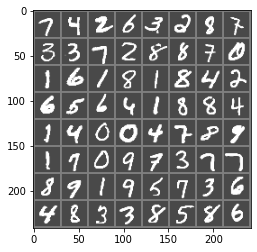

In [55]:
# 展示图像 
# 显示一张图片
def imshow(img):
    img = img / 2 + 0.5      # 逆归一化
    npimg = img.numpy()      # 将张量转换成numpy数组
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose交换维度（0，1，2）转换为（1，2，0） imshow画图
    plt.show()               # 显示图片
    
#
# 得到一些随机训练图像
dataiter = iter(train_loader) # 生成迭代器 
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))#生成网格

In [56]:
images.shape # 64张图像被迭代器用网格输出1个    64x938 =60000-> 64x937+ 1xa=6000

torch.Size([64, 1, 28, 28])

LeNet-5网络的默认的输入图片的尺寸是32*32， 而Mnist数据集的图片的尺寸是28 * 28。

因此，采用Mnist数据集时，每一层的输出的特征值feature map的尺寸与LeNet-5网络的默认默认的feature map的尺寸是不一样的，需要适当的调整。

In [57]:
class LeNet(nn.Module):
       # 定义构造方法函数，用来实例化
    def __init__(self):
        super(LeNet, self).__init__()  # 5层， 2个卷积层+3个fc全连接层
        #1*1*28*28
        # 第一个卷积层：输入通道数=1，输出通道数=6，卷积核大小=5*5，默认步长=1
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6,  kernel_size = 5)   # 6 * 24 * 24 
        # 第二个卷积层：输入通道数=6，输出通道数=16，卷积核大小=5*5，默认步长=1
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)   # 16 * 8 * 8
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features= 120)             # 16 * 4 * 4
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84,  out_features = 10)
        # 第一个全连接层：输入特征数=256，输出特征数=120
        # 也可以理解成：将256个节点连接到120个节点上
        # 第三个全连接层：输入特征数=84，输出特征数=10（这10个维度我们作为0-9的标识来确定识别出的是那个数字。）
        # 也可以理解成：将84个节点连接到10个节点上
    def forward(self, x):
    # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)),(2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.log_softmax(x,dim=1) # 这个问题前面FC建模已经说过了 参考官方LeNet
        return x
  #注解LeNet
# ------------------------------------------------------
# 输出公式 =（M-K+2P）/S +1
# M：输入神经元个数/大小
# K：卷积大小
# P：零填充
# S：步长
#例子
# 原始图像大小：28*28*1
# ------------------------------------------------------
# 第一个卷积层:self.conv1=nn.Conv2d(1,6,5) ：
# 其参数意义为：
#     输入通道为 1 （输入图像是灰度图）
#     输出通道为 6
#     卷积核 kernel_size为 5×5

#     24输出维度 = 28输入维度 - 5卷积核size + 1
#     所以输出 shape 为：6× 24 × 24
# -----------------------------------------------------
# 第一个激活函数：out = F.relu(out)
# 输出维度不变仍为 6 × 24 × 24
# -----------------------------------------------------
# 第一个最大池化层：out = F.max_pool2d(out, 2, 2)
#     该最大池化层在 2x2 空间里向下采样。
#     12输出维度 = 24输入维度 / 2。
#     所以输出 shape 为：6 × 12 × 12
# -----------------------------------------------------
# 第二个卷积层self.conv2=nn.Conv2d(6,16,5)
# 其参数意义为：
#     输入通道为 6 （第一个最大池化层的输出通道数）
#     输出通道为 16 （需要用到的卷积核就有 16 种）
#     卷积核kernel_size为 5×5
#     8输出维度 = 12输入维度 - 5卷积核size + 1
#     所以输出 shape 为：16 × 8 × 8
# ----------------------------------------------------
# 第二个激活函数out = F.relu(out)
# 特征提取结束
# 第二个最大池化层：out = F.max_pool2d(out, 2, 2)
#     该最大池化层在 2x2 空间里向下采样。
#     4输出维度 = 8输入维度 / 2。
#     所以输出 shape 为：16 × 4 × 4
# 输出前的数据预处理
# 因为全连接层Linear的输出为最后的输出，
# 而全连接层Linear要求的输入为展平后的多维的卷积成的特征图（特征图为特征提取部分的结果）

# 输出前的数据预处理结束
# -----------------------------------------------------
# 输出即全连接层

# 第一个全连接层self.fc1=nn.Linear(16*4*4, 120)
# 输入维度为 16* 4 * 4= 256
# 设定的输出维度为 120 × 1
# -----------------------------------------------------
# 激活函数out = F.relu(out)
# 输出维度不变，仍为 120 × 1
# -----------------------------------------------------
# 第二个全连接层self.fc2=nn.Linear(120, 84)
# 输入维度为 84
# 设定的输出维度为 84 × 1
# -----------------------------------------------------
# 第三个激活函数out = F.relu(x)
# 输出维度不变，仍为 84× 1
# 第三个全连接层self.fc3=nn.Linear(84, 10)
# 输入维度为 10 × 1
# 输出维度设定为 10× 1（因为是一个10分类的问题，所以最后要变成 10 × 1）
# -----------------------------------------------------
# 第三个激活函数out = F.log_softmax(out, dim=1)
# 用F.log_softmax()将数据的范围改到[0, 1]之内，表示概率。
# 输出维度仍为 10 × 1，其值可以视为概率。
            
 

In [58]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [59]:
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数，一般分类问题都用 one-hot + Cross-entropy 回归问题 用MSE
learning_rate = 0.01 #设置学习率为0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# 定义 Adam 优化器用于梯度下降 当然也可以用SGD
len(train_loader) # 一共有469个batch

938

In [60]:
def train(epoch):
    run_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):#循环次数batch_idx的最大循环值 +1 = (MNIST数据集样本总数60000/ BATCH_SIZE )
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()#反向计算梯度
        optimizer.step()#优化参数
        run_loss += loss.item()
        if batch_idx % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, run_loss /200))
            run_loss = 0.0

In [61]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():#此时已经不需要计算梯度，也不会进行反向传播
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #将数据转移到cuda上
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)# 将输出结果概率最大的作为预测值，找到概率最大的下标,输出最大值的索引位置
            total += labels.size(0)
            correct += (predicted == labels).sum().item()#正确率累加
    print('accuracy on test set: %d %% ' % (100 * correct / total))
    return correct / total

[1,   200] loss: 0.335
[1,   400] loss: 0.145
[1,   600] loss: 0.114
[1,   800] loss: 0.121
accuracy on test set: 98 % 
[2,   200] loss: 0.093
[2,   400] loss: 0.091
[2,   600] loss: 0.102
[2,   800] loss: 0.098
accuracy on test set: 97 % 
[3,   200] loss: 0.095
[3,   400] loss: 0.091
[3,   600] loss: 0.091
[3,   800] loss: 0.117
accuracy on test set: 97 % 
[4,   200] loss: 0.099
[4,   400] loss: 0.136
[4,   600] loss: 0.094
[4,   800] loss: 0.095
accuracy on test set: 98 % 
[5,   200] loss: 0.076
[5,   400] loss: 0.078
[5,   600] loss: 0.096
[5,   800] loss: 0.099
accuracy on test set: 98 % 
[6,   200] loss: 0.093
[6,   400] loss: 0.093
[6,   600] loss: 0.082
[6,   800] loss: 0.095
accuracy on test set: 98 % 
[7,   200] loss: 0.082
[7,   400] loss: 0.080
[7,   600] loss: 0.109
[7,   800] loss: 0.092
accuracy on test set: 97 % 
[8,   200] loss: 0.079
[8,   400] loss: 0.096
[8,   600] loss: 0.077
[8,   800] loss: 0.105
accuracy on test set: 98 % 
[9,   200] loss: 0.074
[9,   400] loss: 

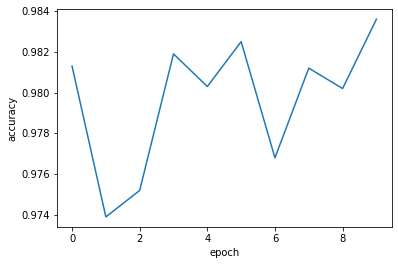

In [62]:
epoch_list = []
acc_list = []
for epoch in range(10):
    train(epoch)
    acc = test()
    epoch_list.append(epoch)
    acc_list.append(acc)
plt.plot(epoch_list, acc_list)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()